In [1]:

# necessary imports
import os
import sqlite3
from PIL import Image, ImageCms
from tqdm import tqdm
import numpy as np
import imagehash
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import colour
from sklearn.cluster import KMeans
icms = ImageCms

In [2]:
# creating a database using sql lite
database_name = "div2k.db"
root_folder = r"D:/data/image_data/pexels_dataset_v1"

conn = sqlite3.connect(database_name)
c = conn.cursor()
c.execute('''CREATE TABLE IF NOT EXISTS Images
                 (ID INTEGER PRIMARY KEY,
                 Name TEXT,
                 Path TEXT,
                 Size INTEGER,
                 Quality TEXT,
                 MeanPixelValue REAL,
                 MeanR,
                 MeanG,
                 MeanB,
                 Variance REAL,
                 PerceptualHash TEXT)''')

# Varianz nutzen wir, da wir damit ermitteln können wie viele Farben drin sind. Also ob das eher ein buntes Bild ist oder eher nicht
conn.commit()



In [2]:
# creating a database using sql lite
database_name = "database_pix.db"
root_folder = r"DIV2k/DIV2K_train_HR/DIV2K_train_HR"

conn = sqlite3.connect(database_name)
c = conn.cursor()
c.execute('''CREATE TABLE IF NOT EXISTS Images
                 (ID INTEGER PRIMARY KEY,
                 Name TEXT,
                 Path TEXT,
                 Size INTEGER
                 )''')

# Varianz nutzen wir, da wir damit ermitteln können wie viele Farben drin sind. Also ob das eher ein buntes Bild ist oder eher nicht
conn.commit()



# Diesen Code Abschnitt lösen sobald die Datenbank erstellt wurde um keine Verwirrung zu stiften

In [35]:
def traverse_folders(root_folder):
    for root, dirs, files in os.walk(root_folder):
        total_files = len(files)
        for i, file in enumerate(files, 1):
            if file.endswith(('.jpg', '.jpeg', '.png','.tiff')): # list all the formats
                file_path = os.path.join(root, file) # get file path
                file_size = os.path.getsize(file_path) # get file size
                image = Image.open(file_path)
                yield (file, file_path, file_size), i / total_files * 100
            else:
                pass 

# Function to insert data into the database
def insert_into_database(database_name, data):
    conn = sqlite3.connect(database_name)
    c = conn.cursor()
    c.execute("INSERT INTO Images (Name, Path, Size) VALUES (?, ?, ?)", data)
    conn.commit()
    
for data, progress in tqdm(traverse_folders(root_folder), total=180000, desc="Processing images", unit="%"):
    insert_into_database(database_name, data)

print("Database creation and data insertion completed.")

Processing images:   0%|          | 800/180000 [00:18<1:10:29, 42.37%/s]

Database creation and data insertion completed.


In [8]:
print(c.fetchall())

[]


# Getting Histogramms of the pictures

In [3]:
c.execute("SELECT Path FROM Images")
paths = c.fetchall()
paths

[('D:/data/image_data/pexels_dataset_v1\\images_01\\1-1-3-374916.jpeg',),
 ('D:/data/image_data/pexels_dataset_v1\\images_01\\1-1-3-text-on-black-chalkboard-374918.jpeg',),
 ('D:/data/image_data/pexels_dataset_v1\\images_01\\1-elephant-beside-on-baby-elephant-66898.jpeg',),
 ('D:/data/image_data/pexels_dataset_v1\\images_01\\1-euro-cent-730647.jpeg',),
 ('D:/data/image_data/pexels_dataset_v1\\images_01\\1-movie-2-signage-under-white-clouds-1200450.jpeg',),
 ('D:/data/image_data/pexels_dataset_v1\\images_01\\1-piece-sliced-pizza-in-white-ceramic-plate-845808.jpeg',),
 ('D:/data/image_data/pexels_dataset_v1\\images_01\\1-u-s-dollar-banknote-lot-259191.jpeg',),
 ('D:/data/image_data/pexels_dataset_v1\\images_01\\1-u-s-dollar-bill-164661.jpeg',),
 ('D:/data/image_data/pexels_dataset_v1\\images_01\\1-us-bank-note-47344.jpeg',),
 ('D:/data/image_data/pexels_dataset_v1\\images_01\\1-us-dollar-banknotes-259132.jpeg',),
 ('D:/data/image_data/pexels_dataset_v1\\images_01\\1-us-dollar-bill-163056

In [4]:

def calculate_histogram(image, color_space):
    if color_space == "HSV":
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hist = cv2.c+alcHist([hsv], [0, 1], None, [180, 256], [0, 180, 0, 256])  # 2D histogram for H and S channels
    elif color_space == "RGB":
        hist = cv2.calcHist([image], [0, 1, 2], None, [64] * 3, [0, 256] * 3)  # Reduced number of bins
    else:
        pass

    # Normalize histogram
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def compute_and_store_histograms(database_image_paths, save_path):
    histograms = {}
    for image_path in database_image_paths:
        print("Processing:", image_path)  # Print the image path
        image = cv2.imread(image_path[0])  # 'image_path' is a tuple, so access the first element
        if image is not None:
            hist = calculate_histogram(image, "HSV")
            histograms[image_path[0]] = hist  # Store the histogram with the original path string
        else:
            print(f"Error: Unable to load image at path {image_path}")
    with open(save_path, 'wb') as f:
        pickle.dump(histograms, f)

def load_histograms_from_file(file_path):
    with open(file_path, 'rb') as f:
        histograms = pickle.load(f)
    return histograms

def bhattacharyya_distance(hist1, hist2):
    return cv2.compareHist(hist1, hist2, cv2.HISTCMP_BHATTACHARYYA)

def find_similar_image(input_image, histograms):
    input_hist = calculate_histogram(input_image,"HSV")
    similarities = []
    for image_path, hist in histograms.items():
        similarity = bhattacharyya_distance(input_hist, hist)  # Use Bhattacharyya distance
        similarities.append((image_path, similarity))
    # Sort images based on similarity
    similarities.sort(key=lambda x: x[1], reverse=False)  # Sort in ascending order of similarity
    return similarities

# Example usage
database_image_paths = paths  # List of paths to database images
database_histogram_file = "histograms_HSV_pix.pkl"

#compute_and_store_histograms(database_image_paths, database_histogram_file)


In [26]:
compute_and_store_histograms(database_image_paths, database_histogram_file)


Processing: ('DIV2k/DIV2K_train_HR/DIV2K_train_HR\\0001.png',)
Processing: ('DIV2k/DIV2K_train_HR/DIV2K_train_HR\\0002.png',)
Processing: ('DIV2k/DIV2K_train_HR/DIV2K_train_HR\\0003.png',)
Processing: ('DIV2k/DIV2K_train_HR/DIV2K_train_HR\\0004.png',)
Processing: ('DIV2k/DIV2K_train_HR/DIV2K_train_HR\\0005.png',)
Processing: ('DIV2k/DIV2K_train_HR/DIV2K_train_HR\\0006.png',)
Processing: ('DIV2k/DIV2K_train_HR/DIV2K_train_HR\\0007.png',)
Processing: ('DIV2k/DIV2K_train_HR/DIV2K_train_HR\\0008.png',)
Processing: ('DIV2k/DIV2K_train_HR/DIV2K_train_HR\\0009.png',)
Processing: ('DIV2k/DIV2K_train_HR/DIV2K_train_HR\\0010.png',)
Processing: ('DIV2k/DIV2K_train_HR/DIV2K_train_HR\\0011.png',)
Processing: ('DIV2k/DIV2K_train_HR/DIV2K_train_HR\\0012.png',)
Processing: ('DIV2k/DIV2K_train_HR/DIV2K_train_HR\\0013.png',)
Processing: ('DIV2k/DIV2K_train_HR/DIV2K_train_HR\\0014.png',)
Processing: ('DIV2k/DIV2K_train_HR/DIV2K_train_HR\\0015.png',)
Processing: ('DIV2k/DIV2K_train_HR/DIV2K_train_HR\\0016

In [7]:
image_path = r"DIV2k/DIV2K_train_HR/DIV2K_train_HR/0747.png"

# Load histograms from file
histograms = load_histograms_from_file(database_histogram_file)

# Example input image
input_image = cv2.imread(image_path)

# Find similar images
similar_images = find_similar_image(input_image, histograms)

# Print top similar images
for image_path, similarity in similar_images[0:5]:  # Print top 10 similar images
    print("Similarity:", similarity)
    print("Image Path:", image_path)

Similarity: 0.34150700717547355
Image Path: D:/data/image_data/pexels_dataset_v1\images_01\brown-and-black-owl-staring-86596.jpeg
Similarity: 0.37197755575954544
Image Path: D:/data/image_data/pexels_dataset_v1\images_05\silhouette-of-human-and-dog-near-body-of-water-1136105.jpeg
Similarity: 0.39670480382280127
Image Path: D:/data/image_data/pexels_dataset_v1\images_03\man-riding-on-motorcycle-479647.jpeg
Similarity: 0.40553775156018596
Image Path: D:/data/image_data/pexels_dataset_v1\images_02\close-up-photograph-of-mushrooms-on-the-ground-13352348.jpeg
Similarity: 0.4203896434623854
Image Path: D:/data/image_data/pexels_dataset_v1\images_04\people-standing-on-camping-site-near-waterfalls-3220760.jpeg


In [20]:
# Function to get mean pixel value and variance of an image

def extract_icc_profile(image_path):
    with Image.open(image_path) as img:
        # Check if the image has an ICC profile
        if "icc_profile" in img.info:
            # Extract the ICC profile
            icc_profile = img.info["icc_profile"]
            # You can then further process the ICC profile as needed
            return icc_profile
        else:
            return None

# Example usage
icc_profile = extract_icc_profile(image_path)
if icc_profile:
    print(icc_profile)
else:
    print("No ICC Profile found in the image.")

    

def get_image_stats(image_path):
    """
    This function gets the following stats of an image:
    - Amount of pixels in the image
    - The Meanpixelvalue
    - Pixel Variance
    - MeanR
    - MeanG
    - MeanB
    """
    with Image.open(image_path) as img:
        pixels = np.array(img)
        mean_pixel_value = np.mean(pixels)
        variance = np.var(pixels)
        
        # Calculate mean R, G, and B values
        mean_r = np.mean(pixels[:, :, 0])  # Red channel
        mean_g = np.mean(pixels[:, :, 1])  # Green channel
        mean_b = np.mean(pixels[:, :, 2])  # Blue channel

        return mean_pixel_value, variance, mean_r, mean_g, mean_b

# Function to compute perceptual hash of an image
def get_perceptual_hash(image_path):
    with Image.open(image_path) as img:
        return str(imagehash.phash(img))

# Generator function to traverse through folders and files
def traverse_folders(root_folder):
    for root, dirs, files in os.walk(root_folder):
        total_files = len(files)
        for i, file in enumerate(files, 1):
            if file.endswith(('.jpg', '.jpeg', '.png','.tiff')): # list all the formats
                file_path = os.path.join(root, file) # get file path
                file_size = os.path.getsize(file_path) # get file size
                image = Image.open(file_path)
                image_quality = image.info.get("quality", "Unknown") # quality or unknown
                average_pixel_value, variance, mean_r, mean_g, mean_b = get_image_stats(file_path)
                perceptual_hash = get_perceptual_hash(file_path)
                yield (file, file_path, file_size, image_quality, average_pixel_value, mean_r, mean_g, mean_b, variance, perceptual_hash), i / total_files * 100
            else:
                pass # Überspringen wenn die Dateiendung nicht wie oben entspricht


b'\x00\x00\x0cHLino\x02\x10\x00\x00mntrRGB XYZ \x07\xce\x00\x02\x00\t\x00\x06\x001\x00\x00acspMSFT\x00\x00\x00\x00IEC sRGB\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf6\xd6\x00\x01\x00\x00\x00\x00\xd3-HP  \x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x11cprt\x00\x00\x01P\x00\x00\x003desc\x00\x00\x01\x84\x00\x00\x00lwtpt\x00\x00\x01\xf0\x00\x00\x00\x14bkpt\x00\x00\x02\x04\x00\x00\x00\x14rXYZ\x00\x00\x02\x18\x00\x00\x00\x14gXYZ\x00\x00\x02,\x00\x00\x00\x14bXYZ\x00\x00\x02@\x00\x00\x00\x14dmnd\x00\x00\x02T\x00\x00\x00pdmdd\x00\x00\x02\xc4\x00\x00\x00\x88vued\x00\x00\x03L\x00\x00\x00\x86view\x00\x00\x03\xd4\x00\x00\x00$lumi\x00\x00\x03\xf8\x00\x00\x00\x14meas\x00\x00\x04\x0c\x00\x00\x00$tech\x00\x00\x040\x00\x00\x00\x0crTRC\x00\x00\x04<\x00\x00\x08\x0cgTRC\x00\x00\x04<\x00\x00\x08\x0cbTRC\x00\x00\x04<\x00\x00\x08\x0ctext\x00\x00\x00\x0

In [21]:
# Function to insert data into the database
def insert_into_database(database_name, data):
    conn = sqlite3.connect(database_name)
    c = conn.cursor()
    c.execute("INSERT INTO Images (Name, Path, Size, Quality, MeanPixelValue, MeanR, MeanG, MeanB, Variance, PerceptualHash) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)", data)
    conn.commit()
    
for data, progress in tqdm(traverse_folders(root_folder), total=180000, desc="Processing images", unit="%"):
    insert_into_database(database_name, data)

print("Database creation and data insertion completed.")

Processing images:   0%|          | 55/180000 [00:13<12:20:53,  4.05%/s]


KeyboardInterrupt: 

In [ ]:
def calculate_cosine_similarity(input_avg_pixel_value, input_pixel_variance, avg_pixel_value, pixel_variance):
    # Convert pixel statistics to numpy arrays
    input_vector = np.array([input_avg_pixel_value, input_pixel_variance])
    image_vector = np.array([avg_pixel_value, pixel_variance])
    
    # Calculate cosine similarity
    dot_product = np.dot(input_vector, image_vector)
    input_magnitude = np.linalg.norm(input_vector)
    image_magnitude = np.linalg.norm(image_vector)
    similarity = dot_product / (input_magnitude * image_magnitude)
    
    return similarity

In [ ]:
import cv2  
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
# Getting the max value for mean and variance
c.execute("SELECT MeanPixelValue FROM Images")
mean_px_val = c.fetchall()

c.execute("SELECT Variance FROM Images")
variance = c.fetchall()

def min_max_normalize(x, X):
    min_val = np.min(X)
    max_val = np.max(X)
    normalized_x = (x - min_val) / (max_val - min_val)
    return normalized_x

Input Mean Pixel: 42.85416643252404
variance_image: 1274.7435595180941
Min_difference_mean: 0.022584530395704405
most_similar_image_id_mean: 277
min_difference_varinace: 8.7189881134409
most_similar_image_id_variance: 339


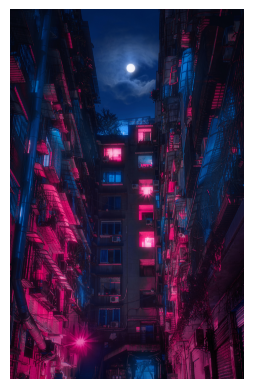

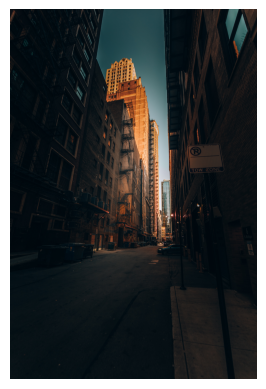

In [ ]:
# Loading image
image = r"D:/data/image_data/extra_collection/insects/david-clode-0eJdryptOHQ-unsplash.jpg"

# Getting mean pixel and variance
mean_px_image, variance_image = get_image_stats(image)
print(f"Input Mean Pixel: {mean_px_image}")
print(f"variance_image: {variance_image}")

# Getting all the meanpx and variance
c.execute("SELECT ID, MeanPixelValue, Variance FROM Images")
images_data = c.fetchall()


# Calculate differences
min_difference_mean = float('inf')
most_similar_image_id_mean = None

min_difference_variance = float('inf')
most_similar_image_id_variance = None

for image_id, avg_pixel_value, pixel_variance in images_data:
    # Calculate the difference between input image statistics and current image statistics
    difference_mean = avg_pixel_value - mean_px_image
    difference_variance = pixel_variance - variance_image
    
    # Update the most similar image if the current difference is smaller
    if difference_mean < min_difference_mean and difference_mean > 0:
        min_difference_mean = difference_mean
        most_similar_image_id_mean = image_id
    
    if difference_variance < min_difference_variance and difference_variance > 0:
        min_difference_variance = difference_variance
        most_similar_image_id_variance = image_id
    
print(f"Min_difference_mean: {min_difference_mean}\nmost_similar_image_id_mean: {most_similar_image_id_mean}")
print(f"min_difference_varinace: {min_difference_variance}\nmost_similar_image_id_variance: {most_similar_image_id_variance}")

# Find the most similar image Mean
c.execute("SELECT Path FROM Images WHERE ID = ?", (most_similar_image_id_mean,))
path = c.fetchone()[0]
img = mpimg.imread(path)

# Plot the image
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()


c.execute("SELECT Path FROM Images WHERE ID = ?", (most_similar_image_id_variance,))
path = c.fetchone()[0]
img = mpimg.imread(path)  # Replace 'path_to_your_image.jpg' with the actual path to your image file

# Plot the image
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()



In [ ]:
"""
1. Getting Stats from the input image
2. Getting Stats from the output image
3. Try to find the lowest difference
4. Output the image
"""

min_distance: 0.02893663756039073


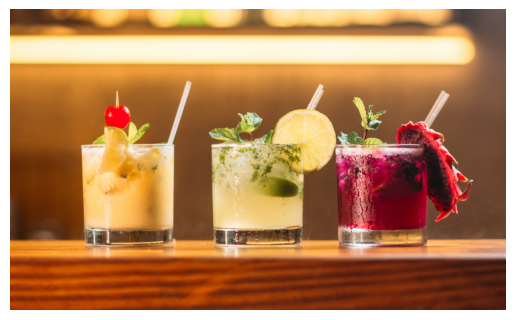

In [ ]:
image = r"D:/audit/GettyImages-1407832840.jpg"

# Getting Stats from the input image
def calculate_distance(rgb1, rgb2):
    distance = np.linalg.norm(np.array(rgb1) - np.array(rgb2))
    max_distance = np.sqrt(3) * 255  # Maximum distance in RGB space
    normalized_distance = distance / max_distance
    return normalized_distance

# Getting Stats from the input image
def get_channel_stats(image_path):
    image = cv2.imread(image_path)
    # Splitting the image into color channels
    b, g, r = cv2.split(image)
    # Calculating mean and variance for each channel
    mean_b = np.mean(b)
    mean_g = np.mean(g)
    mean_r = np.mean(r)
    return (mean_r, mean_g, mean_b)

# Getting the statistics of the output image
c.execute("SELECT ID, MeanPixelValue, MeanR, MeanG, MeanB, Variance FROM Images")
images_data = c.fetchall()

input_rgb = get_channel_stats(image)

# Define a threshold for skipping comparison
threshold_distance = 50  # Adjust this threshold as per your requirement

min_distance = float('inf')
closest_image_id = None

# Fetch a batch of images from the database
batch_size = 100  # Adjust the batch size as per your database size
for batch_start in range(0, len(images_data), batch_size):
    batch = images_data[batch_start:batch_start + batch_size]

    for image_id, avg_pixel_value, r_value, g_value, b_value, pixel_variance in batch:
        # Storing the mean rgb values in a tuple
        rgb_db = (r_value, g_value, b_value)
        
        # Calculating the distance between input image and current database image
        distance = calculate_distance(rgb_db, input_rgb)
        
        # Check if distance is below threshold and update closest image
        if distance < min_distance and distance < threshold_distance:
            min_distance = distance
            closest_image_id = image_id

# Fetch the path of the closest image
c.execute("SELECT Path FROM Images WHERE ID = ?", (closest_image_id,))
path = c.fetchone()[0]

# Load and display the closest image
img = mpimg.imread(path)
print(f"min_distance: {min_distance}")
plt.imshow(img)
plt.axis('off')
plt.show()



    

In [ ]:
image = r"D:/audit/sky-cypresses.jpg"


# Modify the calculate_distance function to include all parameters
def calculate_distance(rgb1, avg_pixel_value1, variance1, rgb2, avg_pixel_value2, variance2):
    rgb_distance = np.linalg.norm(np.array(rgb1) - np.array(rgb2))
    avg_pixel_value_distance = abs(avg_pixel_value1 - avg_pixel_value2)
    variance_distance = abs(variance1 - variance2)
    return rgb_distance + avg_pixel_value_distance + variance_distance

# Modify the get_channel_stats function to include average pixel value and variance
def get_image_stats(image_path):
    image = cv2.imread(image_path)
    b, g, r = cv2.split(image)
    mean_b = np.mean(b)
    mean_g = np.mean(g)
    mean_r = np.mean(r)
    avg_pixel_value = np.mean(image)
    variance = np.var(image)
    return (mean_r, mean_g, mean_b, avg_pixel_value, variance)

c.execute("SELECT ID, MeanPixelValue, MeanR, MeanG, MeanB, Variance FROM Images")
images_data = c.fetchall()



# Fetch and process a batch of images
batch_size = 100  # Adjust the batch size as per your database size
for batch_start in range(0, len(images_data), batch_size):
    batch = images_data[batch_start:batch_start + batch_size]

    for image_id, avg_pixel_value, r_value, g_value, b_value, pixel_variance in batch:
        # Calculate stats for database image
        db_stats = (r_value, g_value, b_value, avg_pixel_value, pixel_variance)
        
        # Calculate stats for input image
        input_stats = get_image_stats(image)
        
        # Calculate the distance
        distance = calculate_distance(db_stats[:3], db_stats[3], db_stats[4], input_stats[:3], input_stats[3], input_stats[4])
        
        # Update the closest image if this one is closer
        if distance < min_distance and distance < threshold_distance:
            min_distance = distance
            closest_image_id = image_id

# Fetch the path of the closest image
c.execute("SELECT Path FROM Images WHERE ID = ?", (closest_image_id,))
path = c.fetchone()[0]

# Load and display the closest image
img = mpimg.imread(path)
print(f"min_distance: {min_distance}")
plt.imshow(img)
plt.axis('off')
plt.show()


KeyboardInterrupt: 

In [ ]:
# Define a function to calculate the mean and variance of each color channel
image_path = r"D:/data/image_data/extra_collection/insects/david-clode-0eJdryptOHQ-unsplash.jpg"


def get_channel_stats(image_path):
    image = cv2.imread(image_path)
    # Splitting the image into color channels
    b, g, r = cv2.split(image)
    # Calculating mean and variance for each channel
    mean_b = np.mean(b)
    mean_g = np.mean(g)
    mean_r = np.mean(r)
    var_b = np.var(b)
    var_g = np.var(g)
    var_r = np.var(r)
    return (mean_b, mean_g, mean_r), (var_b, var_g, var_r)

# Normalize the channel statistics
def normalize_channel_stats(stats):
    normalized_stats = []
    for mean, var in stats:
        mean_norm = mean / 255.0  # Assuming pixel values range from 0 to 255
        var_norm = var / (255.0 ** 2)  # Assuming variance is squared difference
        normalized_stats.append((mean_norm, var_norm))
    return normalized_stats

# Calculate distance for each channel
def calculate_channel_distance(stats1, stats2):
    total_distance = 0
    for i in range(3):  # 3 channels: Red, Green, Blue
        mean_diff = np.abs(stats1[i][0] - stats2[i][0])
        total_distance += channel_distance
    return total_distance

# Get channel statistics for the input image
channel_stats_image = get_channel_stats(image)
print("Input Channel Statistics:", channel_stats_image)

# Normalize channel statistics for the input image
normalized_channel_stats_image = normalize_channel_stats(channel_stats_image)

# Normalize channel statistics for all images in the database
normalized_channel_stats_data = [(image_id, normalize_channel_stats(get_channel_stats(image_path))) for image_id, image_path in images_data]

# Calculate distances for each channel
min_channel_distance = float('inf')
most_similar_image_id_channel = None

for image_id, stats in normalized_channel_stats_data:
    channel_distance = calculate_channel_distance(normalized_channel_stats_image, stats)
    if channel_distance < min_channel_distance:
        min_channel_distance = channel_distance
        most_similar_image_id_channel = image_id

# Retrieve the path of the most similar image based on channel statistics
c.execute("SELECT Path FROM Images WHERE ID = ?", (most_similar_image_id_channel,))
path_channel = c.fetchone()[0]
img_channel = mpimg.imread(path_channel)

# Plot the input image and the most similar image based on channel statistics
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(mpimg.imread(image))
axes[0].set_title('Input Image')
axes[0].axis('off')
axes[1].imshow(img_channel)
axes[1].set_title('Most Similar Image (Channel)')
axes[1].axis('off')
plt.show()


In [ ]:

image_path = r"D:/data/image_data/extra_collection/drinks/ambitious-studio-rick-barrett-UoTlkEmUDMQ-unsplash.jpg"

def extract_icc_profile(image_path):
    with Image.open(image_path) as img:
        # Check if the image has an ICC profile
        if "icc_profile" in img.info:
            # Extract the ICC profile
            icc_profile = img.info["icc_profile"]
            # You can then further process the ICC profile as needed
            return icc_profile
        else:
            return None

# Example usage
icc_profile = extract_icc_profile(image_path)
if icc_profile:
    print(icc_profile)
else:
    print("No ICC Profile found in the image.")
    # Open the image
    image = Image.open(image_path)

    # Convert the image to numpy array
    image_np = np.array(image)

    # Convert the image to sRGB color space
    converted_image_np = colour.RGB_to_RGB(image_np, colour.models.BT709_COLOURSPACE, colour.models.sRGB_COLOURSPACE)

    # Convert the numpy array back to PIL image
    converted_image = Image.fromarray((converted_image_np * 255).astype(np.uint8))

    # Save the converted image
    converted_image.save("output_image.jpg")


b'\x00\x00\x0cHLino\x02\x10\x00\x00mntrRGB XYZ \x07\xce\x00\x02\x00\t\x00\x06\x001\x00\x00acspMSFT\x00\x00\x00\x00IEC sRGB\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf6\xd6\x00\x01\x00\x00\x00\x00\xd3-HP  \x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x11cprt\x00\x00\x01P\x00\x00\x003desc\x00\x00\x01\x84\x00\x00\x00lwtpt\x00\x00\x01\xf0\x00\x00\x00\x14bkpt\x00\x00\x02\x04\x00\x00\x00\x14rXYZ\x00\x00\x02\x18\x00\x00\x00\x14gXYZ\x00\x00\x02,\x00\x00\x00\x14bXYZ\x00\x00\x02@\x00\x00\x00\x14dmnd\x00\x00\x02T\x00\x00\x00pdmdd\x00\x00\x02\xc4\x00\x00\x00\x88vued\x00\x00\x03L\x00\x00\x00\x86view\x00\x00\x03\xd4\x00\x00\x00$lumi\x00\x00\x03\xf8\x00\x00\x00\x14meas\x00\x00\x04\x0c\x00\x00\x00$tech\x00\x00\x040\x00\x00\x00\x0crTRC\x00\x00\x04<\x00\x00\x08\x0cgTRC\x00\x00\x04<\x00\x00\x08\x0cbTRC\x00\x00\x04<\x00\x00\x08\x0ctext\x00\x00\x00\x0